In [1]:
# Import four main libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Import metrics and time
from sklearn import metrics
from time import time

#import necessary library for random oversampling
from imblearn.over_sampling import RandomOverSampler 

# Import modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.tree import plot_tree # visualising the DT tree

# Few ensemble models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [2]:
## Metrics function

def apr(y_pred, y_real):
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

In [3]:
# Load in the dataset
df = pd.read_csv('swan_consulting_data.csv')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


In [6]:
# Mapping columns to get binary results
def columns_binary(x):
    if x == 'Yes':
        return 1
    else:
        return 0

def feature_eng(df):
    # Drop non-useful columns
    df = df.drop(columns = ['CustomerID', 'Country', 'State', 'Churn Label'], axis = 1) # We already have Churn Value which is already a numerical
    
    
    # Churn reason column -- Handle nulls
    df['Churn Reason'] = df['Churn Reason'].fillna('Did not churn')
    
    
    # Change yes/no(including: No internet/Phone services) to binary
    df['Senior Citizen'] = df['Senior Citizen'].apply(columns_binary)
    df['Partner'] = df['Partner'].apply(columns_binary)
    df['Dependents'] = df['Dependents'].apply(columns_binary)
    df['Phone Service'] = df['Phone Service'].apply(columns_binary)
    df['Multiple Lines'] = df['Multiple Lines'].apply(columns_binary)
    df['Online Security'] = df['Online Security'].apply(columns_binary)
    df['Device Protection'] = df['Device Protection'].apply(columns_binary)
    df['Online Backup'] = df['Online Backup'].apply(columns_binary)
    df['Tech Support'] = df['Tech Support'].apply(columns_binary)
    df['Streaming TV'] = df['Streaming TV'].apply(columns_binary)
    df['Streaming Movies'] = df['Streaming Movies'].apply(columns_binary)
    df['Paperless Billing'] = df['Paperless Billing'].apply(columns_binary)

    # Changing columns with only two results to numericals
    df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
    
    # OHE columns
    df = pd.get_dummies(df, columns = ['Internet Service'], drop_first = True, prefix = 'Internet Service', dtype=int)
    df = pd.get_dummies(df, columns = ['Contract'], drop_first = True, prefix = 'Contract', dtype=int)
    df = pd.get_dummies(df, columns = ['Payment Method'], drop_first = True, prefix = 'Payment Method', dtype=int)
    # df = pd.get_dummies(df, columns = ['Churn Reason'], drop_first = True, prefix = 'Churn Reason', dtype=int)

    
    # Scaling 
    # continuous_cols = ['Monthly Charges', 'Total Charges', 'Tenure Months']
    # Standard
    # df[continuous_cols] = scaler_standard.fit_transform(df[continuous_cols])
    # Min-Max Scaling
    # df['continuous_cols'] = scaler_minmax.fit_transform(df['continuous_cols'])
    # Robust
    # df['continuous_cols'] = scaler_robust.fit_transform(df['continuous_cols'])

    
    
    # Upscale / Downscale data to get a balanced churn/non-churned split
    
    
    
    return df

In [13]:
df_fe = feature_eng(df)


In [15]:
df_fe.info() # Should have no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Count                                   7043 non-null   int64  
 1   City                                    7043 non-null   object 
 2   Zip Code                                7043 non-null   int64  
 3   Lat Long                                7043 non-null   object 
 4   Latitude                                7043 non-null   float64
 5   Longitude                               7043 non-null   float64
 6   Gender                                  7043 non-null   int64  
 7   Senior Citizen                          7043 non-null   int64  
 8   Partner                                 7043 non-null   int64  
 9   Dependents                              7043 non-null   int64  
 10  Tenure Months                           7043 non-null   int6

In [17]:
df_fe['Churn Value'].value_counts()

Churn Value
0    5174
1    1869
Name: count, dtype: int64

In [19]:
df_fe.head()

,Count,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,Total Charges,Churn Value,Churn Reason,Internet Service_Fiber optic,Internet Service_No,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,1,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,Competitor made better offer,0,0,0,0,0,0,1
1,1,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,1,0,0,1,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,Moved,1,0,0,0,0,1,0
2,1,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,1,0,0,1,8,1,1,0,0,1,0,1,1,1,99.65,820.5,1,Moved,1,0,0,0,0,1,0
3,1,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,1,0,1,1,28,1,1,0,0,1,1,1,1,1,104.80,3046.05,1,Moved,1,0,0,0,0,1,0
4,1,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,0,0,0,1,49,1,1,0,1,1,0,1,1,1,103.70,5036.3,1,Competitor had better devices,1,0,0,0,0,0,0


In [21]:
def oversample(X,y):
    ''' X = a dataframe containing only the features of the data
        Y = a dataframe containing only the target
    '''
    ros = RandomOverSampler(sampling_strategy='not majority') #define random oversample model
    X_res, y_res = ros.fit_resample(X,y) #fit the random oversample to the data
    return X_res, y_res #return resampled feature and target dataframes

In [23]:
# feature_cols = ['Gender', 'Senior Citizen', 'Partner', 'Dependents','Tenure Months',
#                 'Phone Service', 'Multiple Lines', 'Online Security',
#                 'Online Backup','Device Protection','Tech Support','Streaming TV','Streaming Movies',
#                 'Paperless Billing','Monthly Charges',
#                 'Internet Service_Fiber optic', 'Internet Service_No', 'Contract_One year', 'Contract_Two year',
#                 'Payment Method_Credit card (automatic)','Payment Method_Electronic check','Payment Method_Mailed check']

In [246]:
# StepWise Feature Columns
feature_cols = ['Contract_Two year',
 'Contract_One year',
 'Internet Service_Fiber optic',
 'Dependents',
 'Tenure Months',
 'Internet Service_No',
 'Online Security',
 'Payment Method_Electronic check',
 'Streaming Movies',
 'Tech Support',
 'Paperless Billing',
 'Partner',
 'Streaming TV',
 'Multiple Lines',
 'Monthly Charges']

In [248]:
X = df_fe[feature_cols] # Dataframe which holds all the features
y = df_fe['Churn Value'] # The target to predict

In [250]:
X_res, y_res = oversample(X,y)

In [252]:
# Train/test split data
X_train, X_test, y_train, y_test = train_test_split(X_res, # features
                                                    y_res, # target
                                                    test_size = 0.2, # The % allocated to test
                                                    random_state = 56) # Random state - python will retain the shuffle of dataset

In [254]:
X_train.dtypes

Contract_Two year                    int64
Contract_One year                    int64
Internet Service_Fiber optic         int64
Dependents                           int64
Tenure Months                        int64
Internet Service_No                  int64
Payment Method_Electronic check      int64
Monthly Charges                    float64
dtype: object

In [256]:
y_train

42      1
9148    1
2147    0
9457    1
4599    0
       ..
9338    1
9451    1
3264    0
399     1
2532    0
Name: Churn Value, Length: 8278, dtype: int64

In [258]:
# To check if there is variation in performance
# Create a decision tree
tree = DecisionTreeClassifier(random_state=124)

# Apply cross validation on the tree on the data
# Simulates what would happen if we fit the tree on the data with the following parameters
scores = cross_val_score(tree, # tree itself
                         X_train, # Feature
                         y_train, # Target
                         cv = 5) # The value of K: number of folds

If they differ a lot - it tells us that our model is overfitted to the data! Ideally, we'd want similar scores!

In [261]:
# Check the scores
scores

array([0.85869565, 0.83756039, 0.83333333, 0.85075529, 0.84471299])

In [263]:
# Mean score
sum(scores) / len(scores)

0.8450115299852593

In [265]:
rf = RandomForestClassifier(n_estimators=50) # Random Forests

## Check respective cross validation scores if overfitting need to tune as shown below

rf_score = cross_val_score(rf, X_train, y_train, cv=5)

#Step 1: Select parameters
rf_params = {
    'bootstrap': [False], 
    'n_estimators': [350], # 1 option
    'max_depth': [9], # 1 option
    'min_samples_split': [6], # 1 option
    'min_samples_leaf': [5] # 1 option
}

# Create a grid search object
gs = GridSearchCV(rf,
                  param_grid=rf_params,
                  cv=5,
                  verbose = 1,) # k = 5

# Fit grid search on the training set
gs.fit(X_train, y_train)

# Save my best model as a random forest model
best_rf = gs.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [266]:
## Predict on Train
y_pred = best_rf.predict(X_train)
## Check Accuracy, Precision, Recall & F1
apr(y_pred, y_train)

Accuracy:0.8319642425706693
Precision:0.7974025974025974
Recall:0.8900700652331481
F1:0.8411919168854893


(0.8319642425706693,
 0.7974025974025974,
 0.8900700652331481,
 0.8411919168854893)

In [267]:
## Predict on Test
# Use the model to predict on X_test
y_pred_test = best_rf.predict(X_test)

## Check Accuracy, Precision, Recall & F1
apr(y_pred_test, y_test)

Accuracy:0.8014492753623188
Precision:0.7708333333333334
Recall:0.8579710144927536
F1:0.8120713305898491


(0.8014492753623188,
 0.7708333333333334,
 0.8579710144927536,
 0.8120713305898491)

In [271]:
gs.best_params_

{'bootstrap': False,
 'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 350}

In [201]:
# Valuable metrics

# Get best accuracy score
print(gs.best_score_)

# Fetches best parameters
gs.best_params_

## How well the model does
gs.score(X_train, y_train)

# Explainability of Random Forest/Decision Trees - importance features
print(list(zip(X_train.columns, best_rf.feature_importances_)))

0.8012817257031102
[('Contract_Two year', 0.14444017857488273), ('Contract_One year', 0.06376720204291629), ('Internet Service_Fiber optic', 0.10790984840978468), ('Dependents', 0.09383791798322226), ('Tenure Months', 0.2412157508891714), ('Internet Service_No', 0.04688846298573611), ('Online Security', 0.032408748781731556), ('Payment Method_Electronic check', 0.06224150939395588), ('Streaming Movies', 0.010467354954099216), ('Tech Support', 0.0253785356999446), ('Paperless Billing', 0.022186511139231625), ('Partner', 0.016114994358211825), ('Streaming TV', 0.009155211585800242), ('Multiple Lines', 0.009503249408383306), ('Monthly Charges', 0.11448452379292828)]


### Feature Importance:
- Stepwise and Feature Importance align
- 5% + : Dependents, Tenure Months(most important), Monthly Charges, Internet Service Fibre Optic, Internet Service_No, Contract One Year, Contract_Two Year, Payment Method_Electronic check

- 1% + :'Streaming Movies', 'Tech Support', 'Paperless Billing', 'Partner', 'Streaming TV', 'Multiple Lines', 'Online Security'

In [203]:
## How well the model does
gs.score(X_train, y_train)

0.8280985745349119

In [204]:
gs.score(X_test, y_test)

0.7961352657004831

In [209]:
# Probabilities
# df_fe is the clen dataset
# df_fe_prob = df_fe[df_fe['Churn Value']== 1].copy() need to be same length for proba so will filter out later
df_fe_prob = df_fe.copy()
df_fe_prob 

,Count,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,Total Charges,Churn Value,Churn Reason,Internet Service_Fiber optic,Internet Service_No,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,1,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,Competitor made better offer,0,0,0,0,0,0,1
1,1,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,1,0,0,1,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,Moved,1,0,0,0,0,1,0
2,1,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,1,0,0,1,8,1,1,0,0,1,0,1,1,1,99.65,820.5,1,Moved,1,0,0,0,0,1,0
3,1,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,1,0,1,1,28,1,1,0,0,1,1,1,1,1,104.80,3046.05,1,Moved,1,0,0,0,0,1,0
4,1,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,0,0,0,1,49,1,1,0,1,1,0,1,1,1,103.70,5036.3,1,Competitor had better devices,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,1,0,0,0,72,1,0,0,0,0,0,0,0,1,21.15,1419.4,0,Did not churn,0,1,0,1,0,0,0
7039,1,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,0,0,1,1,24,1,1,1,0,1,1,1,1,1,84.80,1990.5,0,Did not churn,0,0,1,0,0,0,1
7040,1,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,1,0,1,1,72,1,1,0,1,1,0,1,1,1,103.20,7362.9,0,Did not churn,1,0,1,0,1,0,0
7041,1,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,1,0,1,1,11,0,0,1,0,0,0,0,0,1,29.60,346.45,0,Did not churn,0,0,0,0,0,1,0


In [214]:
df_fe_prob = df_fe_prob[feature_cols]

In [216]:
df_fe_prob

,Contract_Two year,Contract_One year,Internet Service_Fiber optic,Dependents,Tenure Months,Internet Service_No,Online Security,Payment Method_Electronic check,Streaming Movies,Tech Support,Paperless Billing,Partner,Streaming TV,Multiple Lines,Monthly Charges
0,0,0,0,0,2,0,1,0,0,0,1,0,0,0,53.85
1,0,0,1,1,2,0,0,1,0,0,1,0,0,0,70.70
2,0,0,1,1,8,0,0,1,1,0,1,0,1,1,99.65
3,0,0,1,1,28,0,0,1,1,1,1,1,1,1,104.80
4,0,0,1,1,49,0,0,0,1,0,1,0,1,1,103.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,0,72,1,0,0,0,0,1,0,0,0,21.15
7039,0,1,0,1,24,0,1,0,1,1,1,1,1,1,84.80
7040,0,1,1,1,72,0,0,0,1,0,1,1,1,1,103.20
7041,0,0,0,1,11,0,1,1,0,0,1,1,0,0,29.60


In [218]:
best_rf.predict_proba(df_fe_prob)[:,1].shape

(7043,)

In [220]:
df_fe_prob[['prob_not_churn', 'prob_churn']] =  best_rf.predict_proba(df_fe_prob)

/var/folders/3b/ldv6cnd11flfp1qdv9w4wc2c0000gn/T/ipykernel_54106/1613517466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fe_prob[['prob_not_churn', 'prob_churn']] =  best_rf.predict_proba(df_fe_prob)
/var/folders/3b/ldv6cnd11flfp1qdv9w4wc2c0000gn/T/ipykernel_54106/1613517466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fe_prob[['prob_not_churn', 'prob_churn']] =  best_rf.predict_proba(df_fe_prob)


In [222]:
df_fe_prob

,Contract_Two year,Contract_One year,Internet Service_Fiber optic,Dependents,Tenure Months,Internet Service_No,Online Security,Payment Method_Electronic check,Streaming Movies,Tech Support,Paperless Billing,Partner,Streaming TV,Multiple Lines,Monthly Charges,prob_not_churn,prob_churn
0,0,0,0,0,2,0,1,0,0,0,1,0,0,0,53.85,0.352652,0.647348
1,0,0,1,1,2,0,0,1,0,0,1,0,0,0,70.70,0.231752,0.768248
2,0,0,1,1,8,0,0,1,1,0,1,0,1,1,99.65,0.269492,0.730508
3,0,0,1,1,28,0,0,1,1,1,1,1,1,1,104.80,0.581344,0.418656
4,0,0,1,1,49,0,0,0,1,0,1,0,1,1,103.70,0.517303,0.482697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,0,72,1,0,0,0,0,1,0,0,0,21.15,0.989070,0.010930
7039,0,1,0,1,24,0,1,0,1,1,1,1,1,1,84.80,0.912249,0.087751
7040,0,1,1,1,72,0,0,0,1,0,1,1,1,1,103.20,0.927590,0.072410
7041,0,0,0,1,11,0,1,1,0,0,1,1,0,0,29.60,0.508667,0.491333


In [224]:
df_fe_prob['Churn Value'] = df_fe['Churn Value']

/var/folders/3b/ldv6cnd11flfp1qdv9w4wc2c0000gn/T/ipykernel_54106/3900244076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fe_prob['Churn Value'] = df_fe['Churn Value']


In [226]:
df_fe_prob

,Contract_Two year,Contract_One year,Internet Service_Fiber optic,Dependents,Tenure Months,Internet Service_No,Online Security,Payment Method_Electronic check,Streaming Movies,Tech Support,Paperless Billing,Partner,Streaming TV,Multiple Lines,Monthly Charges,prob_not_churn,prob_churn,Churn Value
0,0,0,0,0,2,0,1,0,0,0,1,0,0,0,53.85,0.352652,0.647348,1
1,0,0,1,1,2,0,0,1,0,0,1,0,0,0,70.70,0.231752,0.768248,1
2,0,0,1,1,8,0,0,1,1,0,1,0,1,1,99.65,0.269492,0.730508,1
3,0,0,1,1,28,0,0,1,1,1,1,1,1,1,104.80,0.581344,0.418656,1
4,0,0,1,1,49,0,0,0,1,0,1,0,1,1,103.70,0.517303,0.482697,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,0,72,1,0,0,0,0,1,0,0,0,21.15,0.989070,0.010930,0
7039,0,1,0,1,24,0,1,0,1,1,1,1,1,1,84.80,0.912249,0.087751,0
7040,0,1,1,1,72,0,0,0,1,0,1,1,1,1,103.20,0.927590,0.072410,0
7041,0,0,0,1,11,0,1,1,0,0,1,1,0,0,29.60,0.508667,0.491333,0


In [228]:
# False Negative
df_fe_prob[(df_fe_prob['Churn Value'] == 1) & (df_fe_prob['prob_churn'] < 0.5)]

,Contract_Two year,Contract_One year,Internet Service_Fiber optic,Dependents,Tenure Months,Internet Service_No,Online Security,Payment Method_Electronic check,Streaming Movies,Tech Support,Paperless Billing,Partner,Streaming TV,Multiple Lines,Monthly Charges,prob_not_churn,prob_churn,Churn Value
3,0,0,1,1,28,0,0,1,1,1,1,1,1,1,104.80,0.581344,0.418656,1
4,0,0,1,1,49,0,0,0,1,0,1,0,1,1,103.70,0.517303,0.482697,1
5,0,0,0,0,10,0,0,0,0,1,0,1,0,0,55.20,0.515695,0.484305,1
8,0,0,1,1,47,0,0,1,1,0,1,1,1,1,99.35,0.530780,0.469220,1
22,0,0,0,0,5,1,0,0,0,0,0,0,0,0,21.05,0.645235,0.354765,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,1,0,1,0,70,0,0,0,1,0,0,1,1,1,98.30,0.585945,0.414055,1
1855,0,1,0,0,41,0,0,0,1,1,1,1,0,0,66.50,0.562189,0.437811,1
1862,0,0,0,0,4,0,1,0,0,1,1,0,0,0,60.40,0.518635,0.481365,1
1864,0,1,0,0,12,0,0,1,0,1,1,0,1,0,59.80,0.517544,0.482456,1


In [230]:
# False Positive
df_fe_prob[(df_fe_prob['Churn Value'] == 0) & (df_fe_prob['prob_churn'] > 0.5)]

,Contract_Two year,Contract_One year,Internet Service_Fiber optic,Dependents,Tenure Months,Internet Service_No,Online Security,Payment Method_Electronic check,Streaming Movies,Tech Support,Paperless Billing,Partner,Streaming TV,Multiple Lines,Monthly Charges,prob_not_churn,prob_churn,Churn Value
1869,0,0,0,0,1,0,0,1,0,0,1,1,0,0,29.85,0.200297,0.799703,0
1877,0,1,1,0,58,0,0,0,1,0,0,1,1,1,100.35,0.459244,0.540756,0
1878,0,0,1,0,25,0,1,1,1,1,1,0,1,0,105.50,0.413574,0.586426,0
1882,0,0,1,0,21,0,0,1,1,0,1,0,0,0,90.05,0.201130,0.798870,0
1889,0,0,1,0,2,0,0,0,1,0,1,1,1,0,95.50,0.112455,0.887545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,0,1,0,63,0,0,1,1,0,1,1,1,1,103.50,0.323543,0.676457,0
7029,0,0,1,0,18,0,0,0,1,1,1,0,0,1,95.05,0.325171,0.674829,0
7032,0,0,0,0,6,0,0,1,1,0,1,0,1,0,44.40,0.328242,0.671758,0
7035,0,0,1,0,38,0,0,0,0,0,1,0,0,0,69.50,0.391586,0.608414,0


In [232]:
best_rf.estimators_

[DecisionTreeClassifier(max_depth=9, max_features='sqrt', min_samples_leaf=5,
                        min_samples_split=6, random_state=1136227554),
 DecisionTreeClassifier(max_depth=9, max_features='sqrt', min_samples_leaf=5,
                        min_samples_split=6, random_state=1735214541),
 DecisionTreeClassifier(max_depth=9, max_features='sqrt', min_samples_leaf=5,
                        min_samples_split=6, random_state=1920188341),
 DecisionTreeClassifier(max_depth=9, max_features='sqrt', min_samples_leaf=5,
                        min_samples_split=6, random_state=886795183),
 DecisionTreeClassifier(max_depth=9, max_features='sqrt', min_samples_leaf=5,
                        min_samples_split=6, random_state=1783554075),
 DecisionTreeClassifier(max_depth=9, max_features='sqrt', min_samples_leaf=5,
                        min_samples_split=6, random_state=743294547),
 DecisionTreeClassifier(max_depth=9, max_features='sqrt', min_samples_leaf=5,
                        min_sa

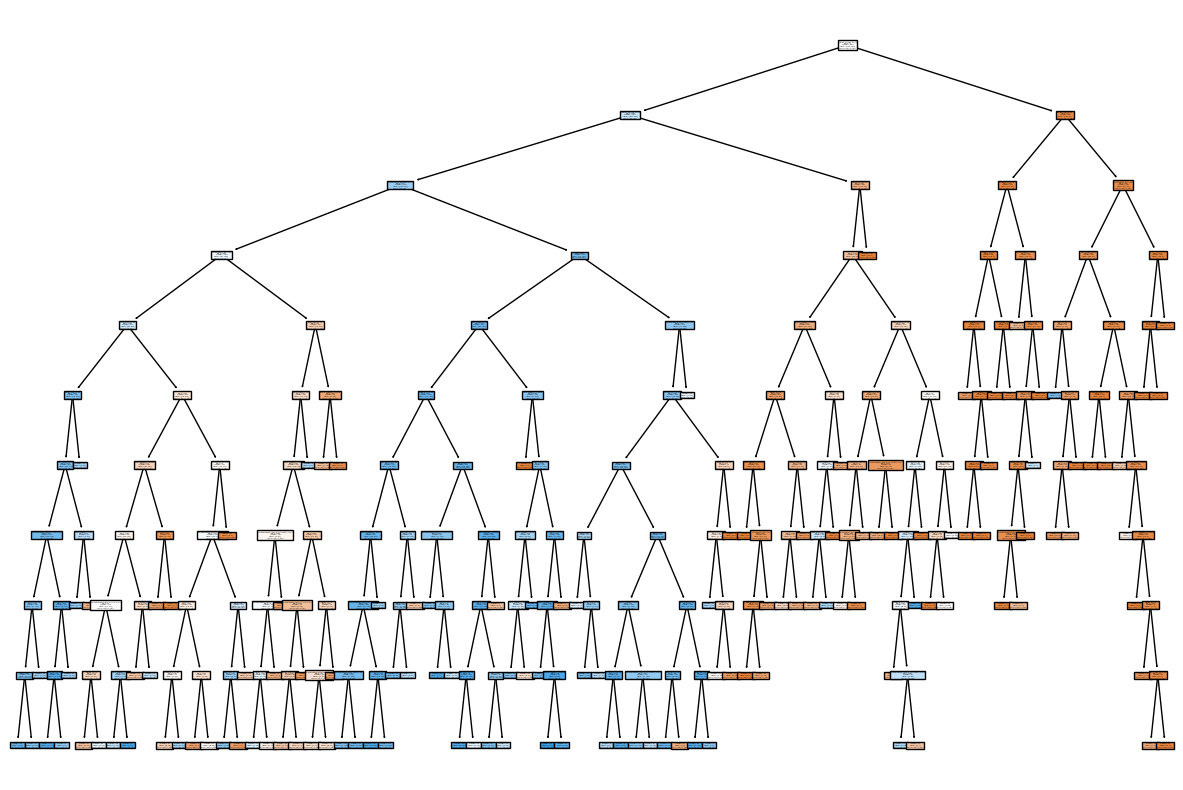

In [86]:
import random

# Get the list of decision trees in the random forest
trees = best_rf.estimators_

# Select a random decision tree from the list
random_tree = random.choice(trees)

# Plot the selected decision tree
fig = plt.figure(figsize=(15, 10))
plot_tree(random_tree, feature_names=feature_cols, class_names=['prob_not_churn', 'prob_churn'], filled=True)
plt.show()